In [112]:
import pandas as pd
import numpy as np
import nltk
from collections import Counter
from nltk.corpus import stopwords
from sklearn.metrics import log_loss
from sklearn.feature_extraction.text import TfidfVectorizer, CountVectorizer
from scipy.optimize import minimize
stops = set(stopwords.words("english"))
import xgboost as xgb
from sklearn.cross_validation import train_test_split
import multiprocessing
import difflib

train = pd.read_csv('../input/train.csv')[:1000]
test = pd.read_csv('../input/test.csv')[:1000]

tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 1))
#cvect = CountVectorizer(stop_words='english', ngram_range=(1, 1))

tfidf_txt = pd.Series(train['question1'].tolist() + train['question2'].tolist() + test['question1'].tolist() + test['question2'].tolist()).astype(str)
tfidf.fit_transform(tfidf_txt)
#cvect.fit_transform(tfidf_txt)

def diff_ratios(st1, st2):
    seq = difflib.SequenceMatcher()
    seq.set_seqs(str(st1).lower(), str(st2).lower())
    return seq.ratio()

def word_match_share(row):
    q1words = {}
    q2words = {}
    for word in str(row['question1']).lower().split():
        if word not in stops:
            q1words[word] = 1
    for word in str(row['question2']).lower().split():
        if word not in stops:
            q2words[word] = 1
    if len(q1words) == 0 or len(q2words) == 0:
        return 0
    shared_words_in_q1 = [w for w in q1words.keys() if w in q2words]
    shared_words_in_q2 = [w for w in q2words.keys() if w in q1words]
    R = (len(shared_words_in_q1) + len(shared_words_in_q2))/(len(q1words) + len(q2words))
    return R

def get_features(df_features):
    print('nouns...')
    df_features['question1_nouns'] = df_features.question1.map(lambda x: [w for w, t in nltk.pos_tag(nltk.word_tokenize(str(x).lower())) if t[:1] in ['N']])
    df_features['question2_nouns'] = df_features.question2.map(lambda x: [w for w, t in nltk.pos_tag(nltk.word_tokenize(str(x).lower())) if t[:1] in ['N']])
    df_features['z_noun_match'] = df_features.apply(lambda r: sum([1 for w in r.question1_nouns if w in r.question2_nouns]), axis=1)  #takes long
    print('lengths...')
    df_features['z_len1'] = df_features.question1.map(lambda x: len(str(x)))
    df_features['z_len2'] = df_features.question2.map(lambda x: len(str(x)))
    df_features['z_word_len1'] = df_features.question1.map(lambda x: len(str(x).split()))
    df_features['z_word_len2'] = df_features.question2.map(lambda x: len(str(x).split()))
    print('difflib...')
    df_features['z_match_ratio'] = df_features.apply(lambda r: diff_ratios(r.question1, r.question2), axis=1)  #takes long
    print('word match...')
    df_features['z_word_match'] = df_features.apply(word_match_share, axis=1, raw=True)
    print('tfidf...')
    df_features['z_tfidf_sum1'] = df_features.question1.map(lambda x: np.sum(tfidf.transform([str(x)]).data))
    df_features['z_tfidf_sum2'] = df_features.question2.map(lambda x: np.sum(tfidf.transform([str(x)]).data))
    df_features['z_tfidf_mean1'] = df_features.question1.map(lambda x: np.mean(tfidf.transform([str(x)]).data))
    df_features['z_tfidf_mean2'] = df_features.question2.map(lambda x: np.mean(tfidf.transform([str(x)]).data))
    df_features['z_tfidf_len1'] = df_features.question1.map(lambda x: len(tfidf.transform([str(x)]).data))
    df_features['z_tfidf_len2'] = df_features.question2.map(lambda x: len(tfidf.transform([str(x)]).data))
    return df_features.fillna(0.0)

train = get_features(train)
#train.to_csv('train.csv', index=False)

col = [c for c in train.columns if c[:1]=='z']

pos_train = train[train['is_duplicate'] == 1]
neg_train = train[train['is_duplicate'] == 0]
p = 0.165
scale = ((len(pos_train) / (len(pos_train) + len(neg_train))) / p) - 1
while scale > 1:
    neg_train = pd.concat([neg_train, neg_train])
    scale -=1
neg_train = pd.concat([neg_train, neg_train[:int(scale * len(neg_train))]])
train = pd.concat([pos_train, neg_train])

x_train, x_valid, y_train, y_valid = train_test_split(train[col], train['is_duplicate'], test_size=0.2, random_state=0)

nouns...
lengths...
difflib...
word match...
tfidf...


/home/takaya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/takaya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


In [2]:
params = {}
params["objective"] = "binary:logistic"
params['eval_metric'] = 'logloss'
params["eta"] = 0.015
params["subsample"] = 0.7
params["min_child_weight"] = 1
params["colsample_bytree"] = 0.7
params["max_depth"] = 6
params["silent"] = 1
params["seed"] = 87978979

d_train = xgb.DMatrix(x_train, label=y_train)
d_valid = xgb.DMatrix(x_valid, label=y_valid)
watchlist = [(d_train, 'train'), (d_valid, 'valid')]
bst = xgb.train(params, d_train, 1000, watchlist, early_stopping_rounds=50, verbose_eval=100) #change to higher #s
print(log_loss(train.is_duplicate, bst.predict(xgb.DMatrix(train[col]))))

test = get_features(test)
#test.to_csv('test.csv', index=False)

sub = pd.DataFrame()
sub['test_id'] = test['test_id']
sub['is_duplicate'] = bst.predict(xgb.DMatrix(test[col]))

sub.to_csv('z08_submission_xgb_01.csv', index=False)

[0]	train-logloss:0.684681	valid-logloss:0.685815
Multiple eval metrics have been passed: 'valid-logloss' will be used for early stopping.

Will train until valid-logloss hasn't improved in 50 rounds.
[100]	train-logloss:0.343008	valid-logloss:0.409543
[200]	train-logloss:0.252018	valid-logloss:0.357266
[300]	train-logloss:0.205578	valid-logloss:0.335646
[400]	train-logloss:0.172183	valid-logloss:0.324186
[500]	train-logloss:0.144044	valid-logloss:0.314333
[600]	train-logloss:0.123835	valid-logloss:0.306247
[700]	train-logloss:0.106516	valid-logloss:0.300592
[800]	train-logloss:0.09263	valid-logloss:0.297124
[900]	train-logloss:0.080607	valid-logloss:0.294489
0.115128546632
nouns...
lengths...
difflib...
word match...
tfidf...


/home/takaya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/numpy/core/_methods.py:59: RuntimeWarning: Mean of empty slice.
  warnings.warn("Mean of empty slice.", RuntimeWarning)
/home/takaya/.pyenv/versions/anaconda3-4.3.0/lib/python3.6/site-packages/numpy/core/_methods.py:70: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


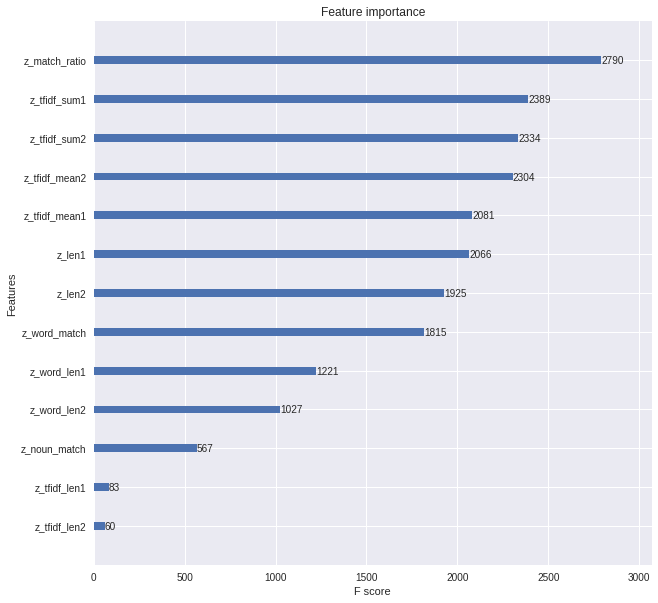

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

plt.rcParams['figure.figsize'] = (10.0, 10.0)
xgb.plot_importance(bst); plt.show()

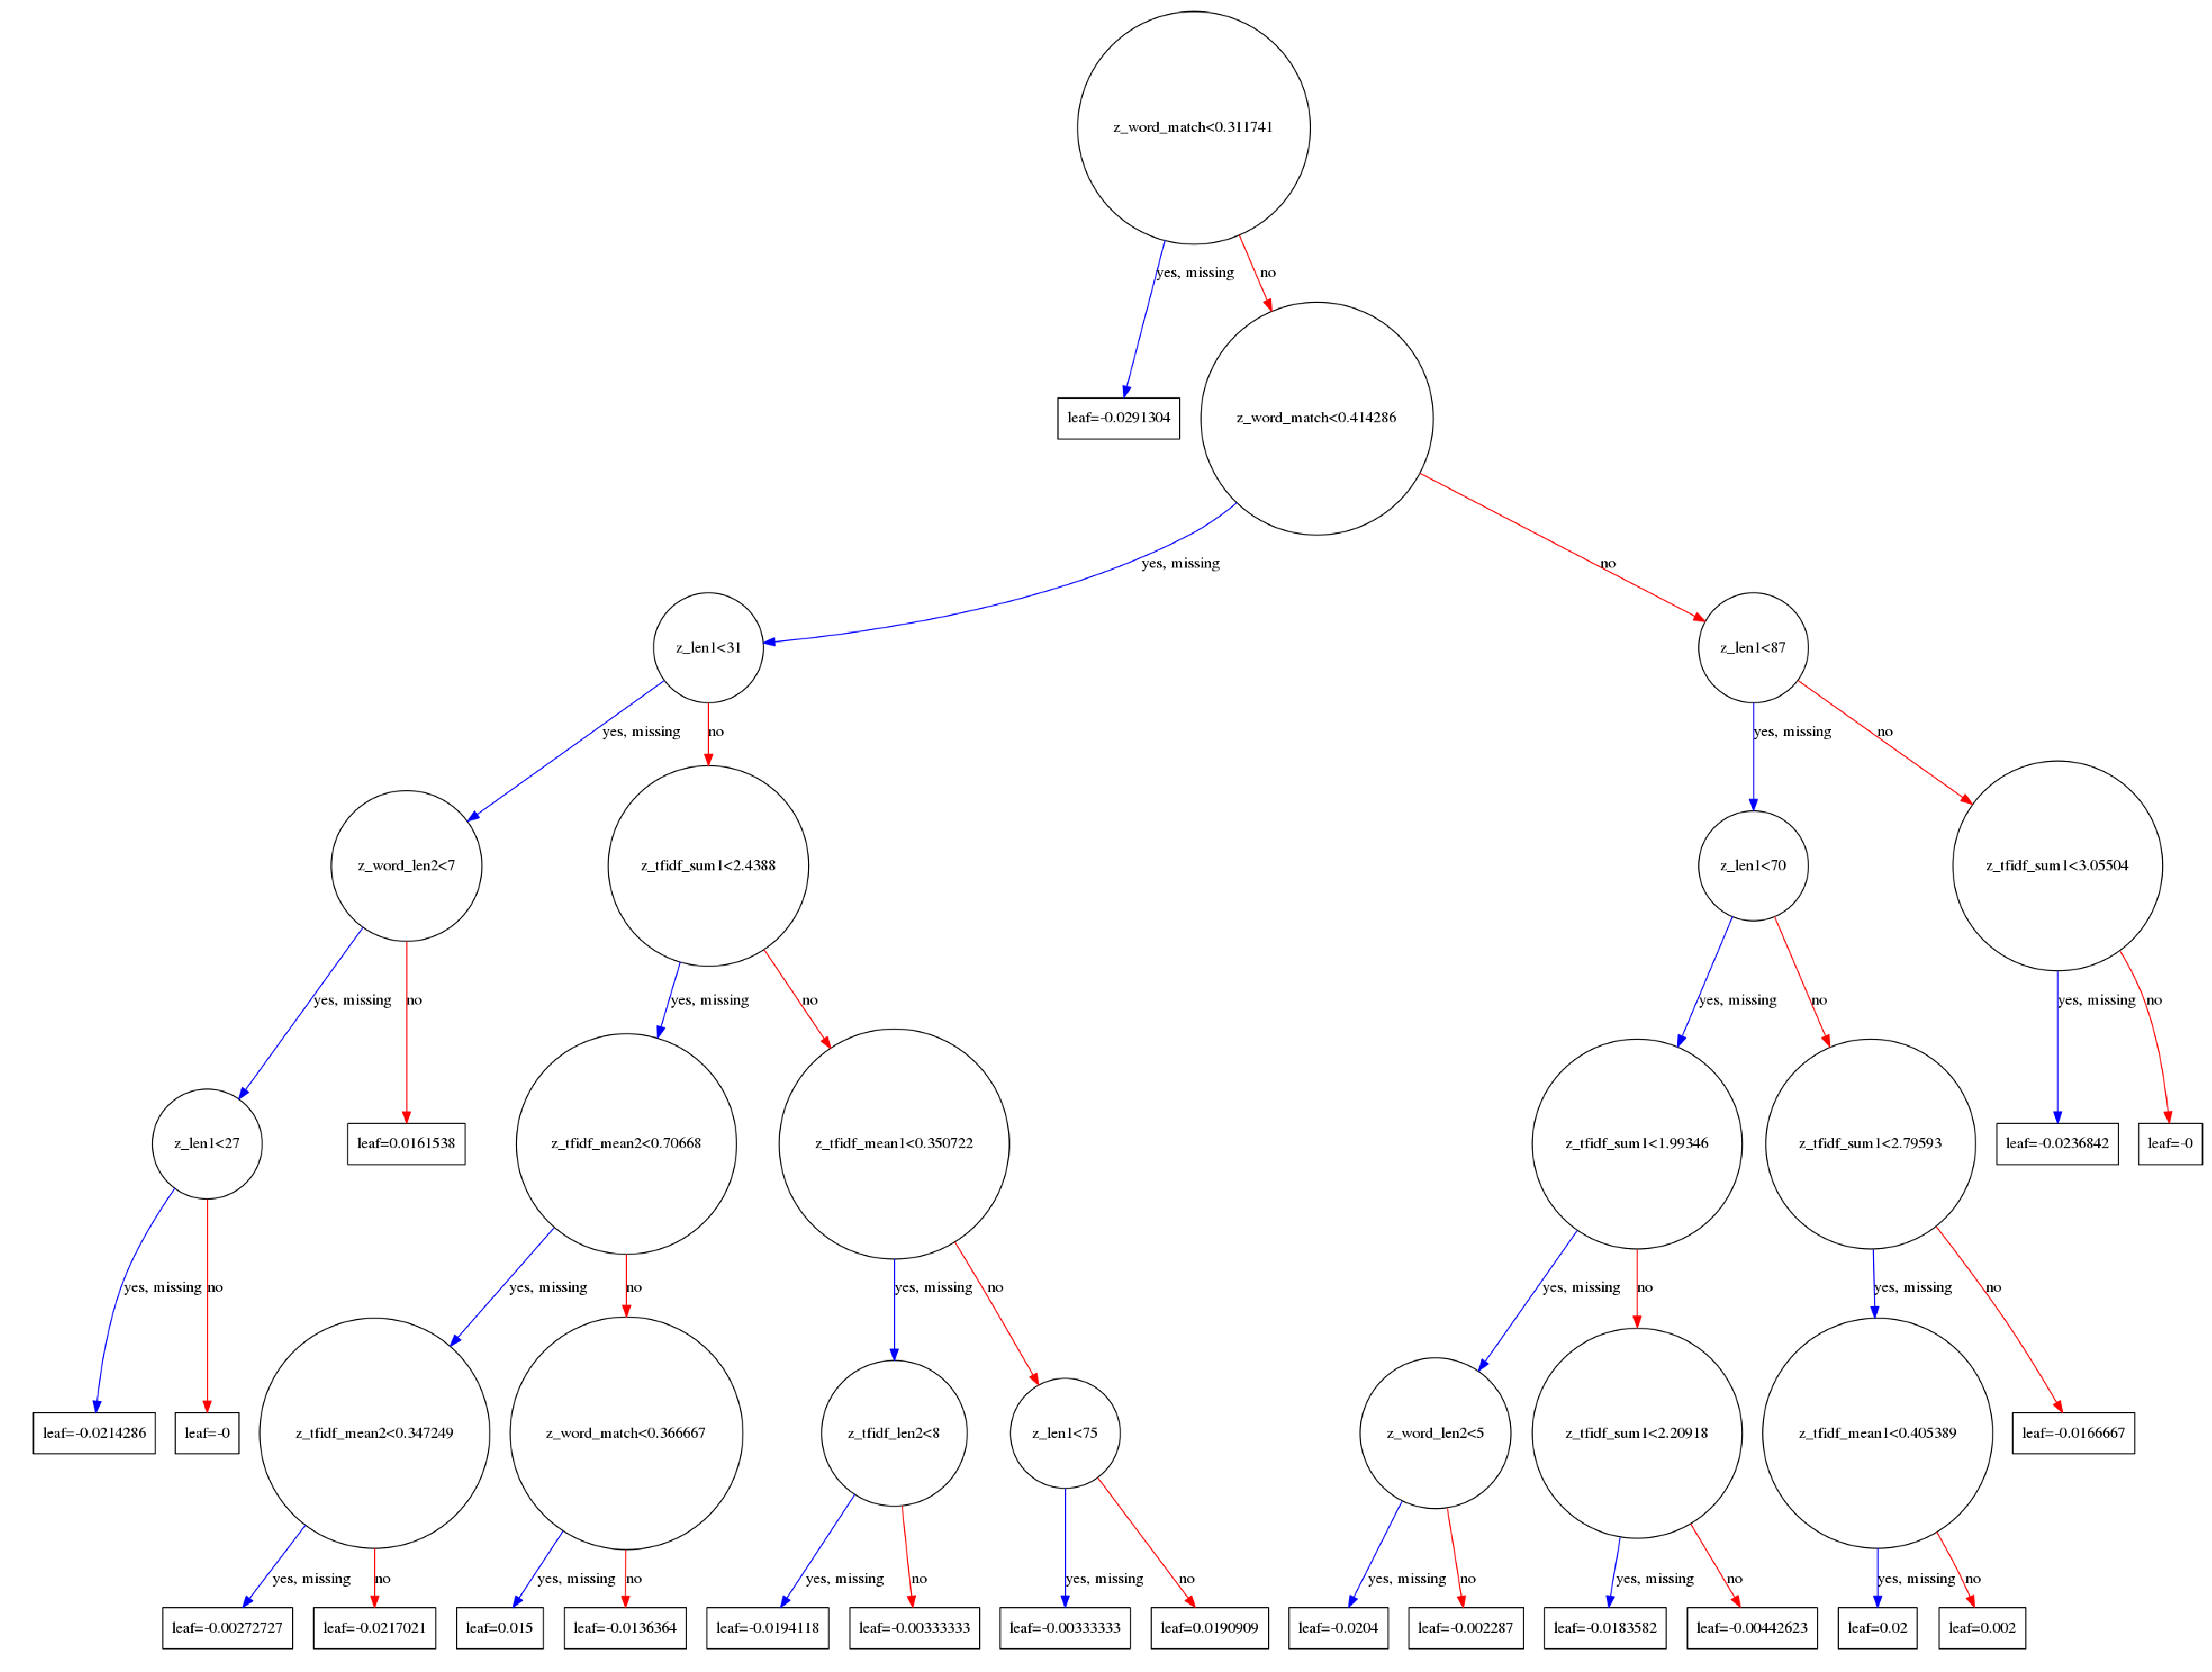

In [4]:
plt.rcParams['figure.figsize'] = (50.0, 50.0)
xgb.plot_tree(bst, num_trees=0); plt.show()

In [80]:
train.loc[:, ['question1', 'question2', 'is_duplicate', 'z_match_ratio', 'z_tfidf_sum1', 'z_tfidf_sum2']]

,question1,question2,is_duplicate,z_match_ratio,z_tfidf_sum1,z_tfidf_sum2
5,Astrology: I am a Capricorn Sun Cap moon and c...,"I'm a triple Capricorn (Sun, Moon and ascendan...",1,0.681818,2.592714,2.424489
7,How can I be a good geologist?,What should I do to be a great geologist?,1,0.619718,1.353642,1.402253
11,How do I read and find my YouTube comments?,How can I see all my Youtube comments?,1,0.765432,1.723798,1.404116
12,What can make Physics easy to learn?,How can you make physics easy to learn?,1,0.880000,1.966875,1.966875
13,What was your first sexual experience like?,What was your first sexual experience?,1,0.938272,1.703701,1.412070
15,What would a Trump presidency mean for current...,How will a Trump presidency affect the student...,1,0.532609,2.970566,2.621693
16,What does manipulation mean?,What does manipulation means?,1,0.982456,1.643752,1.649942
18,Why are so many Quora users posting questions ...,Why do people ask Quora questions which can be...,1,0.593548,2.603153,2.604601
20,Why do rockets look white?,Why are rockets and boosters painted white?,1,0.637681,1.719133,1.986377
29,How should I prepare for CA final law?,How one should know that he/she completely pre...,1,0.654206,1.996784,2.434212


In [58]:
seqm = difflib.SequenceMatcher()
seqm.set_seqs('How can I be a good geologist?'.lower(), 'What should I do to be a great geologist?'.lower())
seqm.ratio()

0.6197183098591549

In [64]:
tfidf = TfidfVectorizer(stop_words='english', ngram_range=(1, 1))
s = pd.Series(train['question1'].tolist() + train['question2'].tolist())
tfidf.fit_transform(s)

<3990x3682 sparse matrix of type '<class 'numpy.float64'>'
	with 20167 stored elements in Compressed Sparse Row format>

In [87]:
tfidf.transform(['How can I be a good geologist?']).data

array([ 0.49415775,  0.86937225])

In [157]:
vectorizer = TfidfVectorizer()
vectorizer

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=True, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), norm='l2', preprocessor=None, smooth_idf=True,
        stop_words=None, strip_accents=None, sublinear_tf=False,
        token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
        vocabulary=None)

In [158]:
corpus = [
    'This is the first document.',
    'This is the second second document.',
    'And the third one.',
    'Is this the first document?',
    'YJSNPI is KUZU',
    'YJSNPI is DUST',
    'YJSNPI is GOD'
]
X = vectorizer.fit_transform(corpus)

In [154]:
vectorizer.get_feature_names()

['and',
 'document',
 'dust',
 'first',
 'god',
 'is',
 'kuzu',
 'one',
 'second',
 'the',
 'third',
 'this',
 'yjsnpi']

In [161]:
vectorizer.transform([' '.join(['This is ', 'is', 'document', 'unko', 'one', 'and', 'YJSNPI', 'YJSNPI'])]).toarray()

array([[ 0.41088774,  0.29153714,  0.        ,  0.        ,  0.        ,
         0.39035767,  0.        ,  0.41088774,  0.        ,  0.        ,
         0.        ,  0.29153714,  0.58307427]])

In [198]:
tfidf.transform(['world destroy']).data

array([ 0.54475894,  0.83859269])

In [201]:
tfidf.transform(['destroy  world ']).data

array([ 0.54475894,  0.83859269])